In [1]:
from __future__ import division
from __future__ import print_function

import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

import gc
from numba import cuda
from numba import jit

In [2]:
# This is how the triagle lattice data is generated. You may find it helpful to generate some 
# of your own data
class Ising_tri():
    ''' Simulating the Ising model '''  
    def __init__(self, size, temp):
        self.temp = temp
        self.N = int(size)
    ## monte carlo moves
    
    def mcmove(self, config, N, beta):
        ''' This is to execute the monte carlo moves using 
        Metropolis algorithm such that detailed
        balance condition is satisified'''
        for i in range(N):
            for j in range(N):            
                    a = np.random.randint(0, N) # select a row
                    b = np.random.randint(0, N) # select a column
                    s =  config[a, b] # current state at (a, b)
                    if a%2:
                        nb = config[(a+1)%N,b] +config[(a+1)%N,(b+1)%N] + config[a,(b+1)%N] + \
                        config[(a-1)%N,b] + config[(a-1)%N,(b+1)%N] + config[a,(b-1)%N]
                    else:
                        nb = config[(a+1)%N,b] +config[(a+1)%N,(b-1)%N] + config[a,(b+1)%N] + \
                        config[(a-1)%N,b] + config[(a-1)%N,(b-1)%N] + config[a,(b-1)%N]
                    
                    
                    cost = 2*s*nb
                    if cost < 0:	
                        s *= -1
                    elif rand() < np.exp(-cost*beta):
                        s *= -1
                    config[a, b] = s
        return config
    
    def simulate(self):   
        ''' This module simulates the Ising model'''
        config = 2*np.random.randint(2, size=(self.N,self.N))-1   
        msrmnt = 81
        for i in range(msrmnt):
            self.mcmove(config, self.N, 1.0/self.temp)
        return config

class Ising_sq():
    ''' Simulating the Ising model '''  
    def __init__(self, size, temp):
        self.temp = temp
        self.N = int(size)
    ## monte carlo moves

    def mcmove(self, config, N, beta):
        ''' This is to execute the monte carlo moves using 
        Metropolis algorithm such that detailed
        balance condition is satisified'''
        for i in range(N):
            for j in range(N):            
                    a = np.random.randint(0, N) # select a row
                    b = np.random.randint(0, N) # select a column
                    s =  config[a, b] # current state at (a, b)
                    # periodic boundary condition imposed
                    nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                    cost = 2*s*nb
                    if cost < 0:
                        s *= -1
                    elif rand() < np.exp(-cost*beta):
                        s *= -1
                    config[a, b] = s
        return config
    
    def simulate(self):   
        ''' This module simulates the Ising model'''
        config = 2*np.random.randint(2, size=(self.N,self.N))-1   
        times = 100
        for i in range(times):
            self.mcmove(config, self.N, 1.0/self.temp)
        return config

You can import 4-temp data for square and triangular lattices as follows

In [3]:
N = 250
nx, ny = 32, 32

Xsq = np.ndarray((4*N,nx,ny,1))
ysq = np.ndarray(4*N)

for i in np.arange(N):
    Xsq[i + 0*N] = np.loadtxt("./square_T1/square_T1/{:03d}".format(i), delimiter=",").reshape(nx,ny,1)
    ysq[i + 0*N] = 0
    Xsq[i + 1*N] = np.loadtxt("./square_T2/square_T2/{:03d}".format(i), delimiter=",").reshape(nx,ny,1)
    ysq[i + 1*N] = 1
    Xsq[i + 2*N] = np.loadtxt("./square_T3/square_T3/{:03d}".format(i), delimiter=",").reshape(nx,ny,1)
    ysq[i + 2*N] = 2
    Xsq[i + 3*N] = np.loadtxt("./square_T4/square_T4/{:03d}".format(i), delimiter=",").reshape(nx,ny,1)
    ysq[i + 3*N] = 3

Xsq_train, Xsq_test, ysq_train, ysq_test = train_test_split(Xsq, ysq, test_size=0.2, random_state=0)

In [4]:
N = 250
nx, ny = 32, 32

Xtri = np.ndarray((4*N,nx,ny,1))
ytri = np.ndarray(4*N)

for i in np.arange(N):
    Xtri[i + 0*N] = np.loadtxt("./triangle_T1/triangle_T1/{:03d}".format(i), delimiter=",").reshape(nx,ny,1)
    ytri[i + 0*N] = 0
    Xtri[i + 1*N] = np.loadtxt("./triangle_T2/triangle_T2/{:03d}".format(i), delimiter=",").reshape(nx,ny,1)
    ytri[i + 1*N] = 1
    Xtri[i + 2*N] = np.loadtxt("./triangle_T3/triangle_T3/{:03d}".format(i), delimiter=",").reshape(nx,ny,1)
    ytri[i + 2*N] = 2
    Xtri[i + 3*N] = np.loadtxt("./triangle_T4/triangle_T4/{:03d}".format(i), delimiter=",").reshape(nx,ny,1)
    ytri[i + 3*N] = 3

Xtri_train, Xtri_test, ytri_train, ytri_test = train_test_split(Xtri, ytri, test_size=0.2, random_state=0)

Make sure you know the shape of data.

In [5]:
print("Shape of training data:")
print(Xsq_train.shape, Xtri_train.shape)
print(ysq_train.shape, ytri_train.shape)
print("Shape of test data:")
print(Xsq_test.shape, Xtri_test.shape)
print(ysq_test.shape, ytri_test.shape)

Shape of training data:
(800, 32, 32, 1) (800, 32, 32, 1)
(800,) (800,)
Shape of test data:
(200, 32, 32, 1) (200, 32, 32, 1)
(200,) (200,)


### (a) Train a fully connected neural network to do the classification on both datasets. Then, train  a  convolutional  neural  network  to  do  the  classification,  on  both datasets.   Make  a  table  of  your  performance  numbers  for  both  models  and  upload  these  numbers.   This,  together  with  your code,  should be uploaded to the course website when you turn in your homework.

The temperatures for square lattice are $T = 1.5, 2.1, 2.4, 3.5$. $T = 2.5, 3.2, 3.8, 5$ for triangle lattice.


Solution to (a):

In [6]:
class small_FNN:
    def __init__(self):
        model = self
    
    @staticmethod
    def build(width, height, depth, num_classes, channels_first=False):
        model = Sequential()

        if channels_first == False:
            inputShape = (height, width, depth)
            chanDim = -1
        elif channels_first == True:
            inputShape = (depth, height, width)
            chanDim = 1
            
        model.add(Flatten())
        
        model.add(Dense(256,  activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        
        model.add(Dense(128,  activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        
        model.add(Dense(num_classes, activation="softmax"))
        
        return model

In [7]:
def train_model(input_model, train_data, train_lbls, test_data, 
                test_lbls, num_classes, input_shape, hyperparams):
    # Ensure data is shaped properly, assumes channels last set up
    x_train = train_data
    x_test = test_data
    
    # Create categorical labels
    y_train = keras.utils.to_categorical(train_lbls, num_classes)
    y_test = keras.utils.to_categorical(test_lbls, num_classes)
     
    # Set hyperparameters
    INIT_LR = hyperparams[0]# learning rate
    EPOCHS = hyperparams[1] # number of epochs
    BS = hyperparams[2] # batch size
    OPT = optimizers.Adagrad(lr=INIT_LR) # optimizing function
    
    model = input_model
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=OPT, metrics=['accuracy'])
    
    
    H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=EPOCHS,
                  batch_size=BS)
    
    return H, model
    

In [8]:
input_shape = (32, 32, 1)
num_classes = 4
fnn_model_sq = small_FNN.build(width=input_shape[0], height=input_shape[1], depth=input_shape[2],
                   num_classes=num_classes)
fnn_model_tri = small_FNN.build(width=input_shape[0], height=input_shape[1], depth=input_shape[2],
                   num_classes=num_classes)

# hyperparams should be a tuple of: INIT_LR, EPOCHS, BS
FNN_hyperparams = (0.01, 50, 32)
H_sq_FNN, sq_FNN_model = train_model(fnn_model_sq, Xsq_train, ysq_train, Xsq_test, ysq_test, num_classes, input_shape, FNN_hyperparams)
H_tri_FNN, tri_FNN_model = train_model(fnn_model_tri, Xtri_train, ytri_train, Xtri_test, ytri_test, num_classes, input_shape, FNN_hyperparams)

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 1s 1ms/sample - loss: 1.7569 - accuracy: 0.2463 - val_loss: 1.4259 - val_accuracy: 0.2350
Epoch 2/50
800/800 [==============================] - 0s 113us/sample - loss: 1.4908 - accuracy: 0.3200 - val_loss: 1.3649 - val_accuracy: 0.2900
Epoch 3/50
800/800 [==============================] - 0s 103us/sample - loss: 1.4420 - accuracy: 0.3562 - val_loss: 1.3567 - val_accuracy: 0.3000
Epoch 4/50
800/800 [==============================] - 0s 129us/sample - loss: 1.2978 - accuracy: 0.4238 - val_loss: 1.3165 - val_accuracy: 0.3600
Epoch 5/50
800/800 [==============================] - 0s 108us/sample - loss: 1.2472 - accuracy: 0.4363 - val_loss: 1.2665 - val_accuracy: 0.4150
Epoch 6/50
800/800 [==============================] - 0s 106us/sample - loss: 1.2032 - accuracy: 0.4588 - val_loss: 1.2442 - val_accuracy: 0.4200
Epoch 7/50
800/800 [==============================] - 0s 105us/sample - loss: 1.

800/800 [==============================] - 0s 102us/sample - loss: 1.3201 - accuracy: 0.4200 - val_loss: 1.3674 - val_accuracy: 0.2650
Epoch 7/50
800/800 [==============================] - 0s 103us/sample - loss: 1.3033 - accuracy: 0.4162 - val_loss: 1.3276 - val_accuracy: 0.3100
Epoch 8/50
800/800 [==============================] - 0s 101us/sample - loss: 1.2170 - accuracy: 0.4512 - val_loss: 1.2915 - val_accuracy: 0.3300
Epoch 9/50
800/800 [==============================] - 0s 99us/sample - loss: 1.1948 - accuracy: 0.4825 - val_loss: 1.2557 - val_accuracy: 0.3400
Epoch 10/50
800/800 [==============================] - 0s 100us/sample - loss: 1.1633 - accuracy: 0.4613 - val_loss: 1.2197 - val_accuracy: 0.3800
Epoch 11/50
800/800 [==============================] - 0s 102us/sample - loss: 1.1086 - accuracy: 0.5113 - val_loss: 1.1944 - val_accuracy: 0.4000
Epoch 12/50
800/800 [==============================] - 0s 100us/sample - loss: 1.0975 - accuracy: 0.5163 - val_loss: 1.1639 - val_accu

### (b) Train a convolutional neural network to do the classification, on both datasets. Make a table of your performance numbers for (a) and (b). 
Try to optimize the performance of your models and compare the result.

solution to (b):

In [9]:
class SimpleCNN:
    def __init__(self):
        model = self
    
    @staticmethod
    def build(width, height, depth, num_classes, channels_first=False):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        
        if channels_first == False:
            inputShape = (height, width, depth)
            chanDim = -1
        elif channels_first == True:
            inputShape = (depth, height, width)
            chanDim = 1
            
        model.add(Conv2D(32, (5, 5), activation='relu', input_shape=inputShape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Dropout(0.25))
                  
        model.add(Flatten())
        model.add(Dropout(0.4))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(num_classes, activation='softmax'))

        # return the constructed network architecture
        return model

In [10]:
input_shape = (32, 32, 1)
num_classes = 4
cnn_model_sq = SimpleCNN.build(width=input_shape[0], height=input_shape[1], depth=input_shape[2],
                   num_classes=num_classes)
cnn_model_tri = SimpleCNN.build(width=input_shape[0], height=input_shape[1], depth=input_shape[2],
                   num_classes=num_classes)

CNN_hyperparams = (0.01, 50, 64)
H_sq_CNN, sq_CNN_model = train_model(cnn_model_sq, Xsq_train, ysq_train, Xsq_test, ysq_test, num_classes, input_shape, CNN_hyperparams)
H_tri_CNN, tri_CNN_model = train_model(cnn_model_tri, Xtri_train, ytri_train, Xtri_test, ytri_test, num_classes, input_shape, CNN_hyperparams)

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 1s 2ms/sample - loss: 1.3636 - accuracy: 0.2763 - val_loss: 1.2995 - val_accuracy: 0.2600
Epoch 2/50
800/800 [==============================] - 0s 76us/sample - loss: 1.2683 - accuracy: 0.3850 - val_loss: 1.1509 - val_accuracy: 0.5000
Epoch 3/50
800/800 [==============================] - 0s 76us/sample - loss: 1.0575 - accuracy: 0.5412 - val_loss: 0.8781 - val_accuracy: 0.6300
Epoch 4/50
800/800 [==============================] - 0s 92us/sample - loss: 0.9009 - accuracy: 0.5900 - val_loss: 0.8027 - val_accuracy: 0.6000
Epoch 5/50
800/800 [==============================] - 0s 83us/sample - loss: 0.7093 - accuracy: 0.6750 - val_loss: 0.9803 - val_accuracy: 0.4650
Epoch 6/50
800/800 [==============================] - 0s 80us/sample - loss: 0.7773 - accuracy: 0.6288 - val_loss: 0.7067 - val_accuracy: 0.6400
Epoch 7/50
800/800 [==============================] - 0s 76us/sample - loss: 0.5538 -

800/800 [==============================] - 0s 80us/sample - loss: 0.7404 - accuracy: 0.6513 - val_loss: 0.9750 - val_accuracy: 0.4300
Epoch 7/50
800/800 [==============================] - 0s 79us/sample - loss: 0.6277 - accuracy: 0.7287 - val_loss: 0.8288 - val_accuracy: 0.5650
Epoch 8/50
800/800 [==============================] - 0s 77us/sample - loss: 0.5838 - accuracy: 0.7163 - val_loss: 0.5379 - val_accuracy: 0.7250
Epoch 9/50
800/800 [==============================] - 0s 72us/sample - loss: 0.4577 - accuracy: 0.7975 - val_loss: 0.6588 - val_accuracy: 0.6800
Epoch 10/50
800/800 [==============================] - 0s 80us/sample - loss: 0.6912 - accuracy: 0.6950 - val_loss: 0.4497 - val_accuracy: 0.8150
Epoch 11/50
800/800 [==============================] - 0s 78us/sample - loss: 0.4255 - accuracy: 0.8238 - val_loss: 0.4866 - val_accuracy: 0.7750
Epoch 12/50
800/800 [==============================] - 0s 80us/sample - loss: 0.3745 - accuracy: 0.8512 - val_loss: 0.4838 - val_accuracy: 

### (c) We have provided a test set of 10 spins configurations for each of the two problems. Each of the spin configurations is not necessarily at the temperatures of the training sets. Calculate your best estimate of the temperatures of these spin configuration. Upload your results to Kaggle.
[Hint: A direct fingerprint of temperature is the distribution of spin up
and down, because you can image that the spins fluctuate more violently
at higher temperature. Although the mothod you use in homework 2 can also work, you may be interested in trying to take distribution into account when you
build the model to estimate temperature and see if you can make use of this extra information. This may help you win the
kaggle. It is totally fine if you find that the information of distribution is not helpful. Note also that a CNN kind-of does this. One possibility is that you may want a CNN that captures enough distribution information.]

Solution to (c)

In [11]:
cwd = str(os.getcwd())
sq_sim_data_path = cwd+"/sq_sim_data.npy"
tri_sim_data_path = cwd+"/tri_sim_data.npy"

temps_vec = np.linspace(0.01,15,num=1500)

"""
sq_sim_data = []
tri_sim_data = []
sim_data_temp = []

for temp in temps_vec:    
    sq_ising_simu = Ising_sq(32, temp)
    tri_ising_simu = Ising_tri(32, temp)
    sq_img = sq_ising_simu.simulate()
    tri_img = tri_ising_simu.simulate()
    
    sq_sim_data.append(sq_img)
    tri_sim_data.append(tri_img)
    
cwd = str(os.getcwd())
sim_data_path_2 = cwd+"/sim_data_2.npy"
sim_data_temp_path_2 = cwd+"/sim_data_temp_2.npy"
sim_data_tot_lv_mean_path = cwd+"/sim_data_tot_lv_mean.npy"

np.save(sq_sim_data_path, np.asarray(sq_sim_data))
np.save(tri_sim_data_path, np.asarray(tri_sim_data))
"""

'\nsq_sim_data = []\ntri_sim_data = []\nsim_data_temp = []\n\nfor temp in temps_vec:    \n    sq_ising_simu = Ising_sq(32, temp)\n    tri_ising_simu = Ising_tri(32, temp)\n    sq_img = sq_ising_simu.simulate()\n    tri_img = tri_ising_simu.simulate()\n    \n    sq_sim_data.append(sq_img)\n    tri_sim_data.append(tri_img)\n    \ncwd = str(os.getcwd())\nsim_data_path_2 = cwd+"/sim_data_2.npy"\nsim_data_temp_path_2 = cwd+"/sim_data_temp_2.npy"\nsim_data_tot_lv_mean_path = cwd+"/sim_data_tot_lv_mean.npy"\n\nnp.save(sq_sim_data_path, np.asarray(sq_sim_data))\nnp.save(tri_sim_data_path, np.asarray(tri_sim_data))\n'

In [12]:
# Get the data ready to be embedded
sq_sim_img = np.load(sq_sim_data_path).reshape(1500,32,32,-1)
tri_sim_img = np.load(tri_sim_data_path).reshape(1500,32,32,-1)

In [13]:
sq_sim_img_rs, tri_sim_img_rs = np.repeat(sq_sim_img, 5, 1), np.repeat(tri_sim_img, 5, 1)
sq_sim_img_rs, tri_sim_img_rs = np.repeat(sq_sim_img_rs, 5, 2), np.repeat(tri_sim_img_rs, 5, 2)
sq_sim_img_rs, tri_sim_img_rs = np.repeat(sq_sim_img_rs, 3, 3), np.repeat(tri_sim_img_rs, 3, 3)

In [14]:
# Get pre-trained MobileNetV2 
with tf.device('/CPU:0'):
    base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                                   include_top=False,
                                                   weights='imagenet',
                                                   classes=4)
    base_model.trainable = False

In [15]:
# Get the embedded data
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()

sq_sim_data_emb = global_avg_layer(base_model.predict(sq_sim_img_rs))
sq_sim_data_emb = sq_sim_data_emb.numpy()/sq_sim_data_emb.numpy().max()

tri_sim_data_emb = global_avg_layer(base_model.predict(tri_sim_img_rs))
tri_sim_data_emb = tri_sim_data_emb.numpy()/tri_sim_data_emb.numpy().max()

In [16]:
# Get train/test splits
sq_x_train, sq_x_test, sq_y_train, sq_y_test = train_test_split(sq_sim_data_emb, temps_vec, test_size=0.2, random_state=0)
tri_x_train, tri_x_test, tri_y_train, tri_y_test = train_test_split(tri_sim_data_emb, temps_vec, test_size=0.2, random_state=0)

In [17]:
# Define the model
class RegressionHead:
    def __init__(self):
        model = self
    
    @staticmethod
    def build(channels_first=False):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(612, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.25))
        model.add(tf.keras.layers.Dense(32, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.25))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(1, activation='linear'))
        
        return model

In [18]:
INIT_LR = 0.01# learning rate
EPOCHS = 50 # number of epochs
BS = 32 # batch size
OPT = optimizers.Adagrad(lr=INIT_LR) # optimizing function
LOSS = keras.losses.MeanSquaredError()

sq_reg_model = RegressionHead.build()
sq_reg_model.compile(optimizer=OPT, loss=LOSS, metrics=['MeanSquaredError'])
sq_reg_H = sq_reg_model.fit(sq_x_train, sq_y_train, validation_data=(sq_x_test, sq_y_test), epochs=EPOCHS,
                  batch_size=BS)

Train on 1200 samples, validate on 300 samples
Epoch 1/50
1200/1200 [==============================] - 1s 555us/sample - loss: 55.1380 - MeanSquaredError: 55.1380 - val_loss: 48.3800 - val_MeanSquaredError: 48.3800
Epoch 2/50
1200/1200 [==============================] - 0s 76us/sample - loss: 41.0185 - MeanSquaredError: 41.0185 - val_loss: 47.6785 - val_MeanSquaredError: 47.6785
Epoch 3/50
1200/1200 [==============================] - 0s 78us/sample - loss: 32.2175 - MeanSquaredError: 32.2175 - val_loss: 38.0394 - val_MeanSquaredError: 38.0394
Epoch 4/50
1200/1200 [==============================] - 0s 89us/sample - loss: 25.2200 - MeanSquaredError: 25.2200 - val_loss: 21.8155 - val_MeanSquaredError: 21.8155
Epoch 5/50
1200/1200 [==============================] - 0s 75us/sample - loss: 19.3599 - MeanSquaredError: 19.3599 - val_loss: 21.1247 - val_MeanSquaredError: 21.1247
Epoch 6/50
1200/1200 [==============================] - 0s 77us/sample - loss: 15.2664 - MeanSquaredError: 15.2664 - 

1200/1200 [==============================] - 0s 79us/sample - loss: 3.8450 - MeanSquaredError: 3.8450 - val_loss: 4.6188 - val_MeanSquaredError: 4.6188


In [19]:
INIT_LR = 0.01# learning rate
EPOCHS = 50 # number of epochs
BS = 32 # batch size
OPT = optimizers.Adagrad(lr=INIT_LR) # optimizing function
LOSS = keras.losses.MeanSquaredError()

tri_reg_model = RegressionHead.build()
tri_reg_model.compile(optimizer=OPT, loss=LOSS, metrics=['MeanSquaredError'])
tri_reg_H = tri_reg_model.fit(tri_x_train, tri_y_train, validation_data=(tri_x_test, tri_y_test), epochs=EPOCHS,
                  batch_size=BS)

Train on 1200 samples, validate on 300 samples
Epoch 1/50
1200/1200 [==============================] - 0s 373us/sample - loss: 52.5781 - MeanSquaredError: 52.5781 - val_loss: 46.2019 - val_MeanSquaredError: 46.2019
Epoch 2/50
1200/1200 [==============================] - 0s 81us/sample - loss: 39.2319 - MeanSquaredError: 39.2319 - val_loss: 36.2275 - val_MeanSquaredError: 36.2275
Epoch 3/50
1200/1200 [==============================] - 0s 78us/sample - loss: 29.8982 - MeanSquaredError: 29.8982 - val_loss: 31.5353 - val_MeanSquaredError: 31.5353
Epoch 4/50
1200/1200 [==============================] - 0s 79us/sample - loss: 22.9369 - MeanSquaredError: 22.9369 - val_loss: 26.8321 - val_MeanSquaredError: 26.8321
Epoch 5/50
1200/1200 [==============================] - 0s 78us/sample - loss: 17.5142 - MeanSquaredError: 17.5142 - val_loss: 18.4955 - val_MeanSquaredError: 18.4955
Epoch 6/50
1200/1200 [==============================] - 0s 74us/sample - loss: 13.8613 - MeanSquaredError: 13.8613 - 

1200/1200 [==============================] - 0s 86us/sample - loss: 3.0658 - MeanSquaredError: 3.0658 - val_loss: 1.8976 - val_MeanSquaredError: 1.8976


In [20]:
sq_sim_data_probas = sq_CNN_model.predict_proba(sq_sim_img)
tri_sim_data_probas = sq_CNN_model.predict_proba(tri_sim_img)

In [21]:
def T_import(dir):
    temp = []
    for i in range(len(os.listdir(dir+'/'))):
        temp.append(np.loadtxt((dir+'/')+str(i).zfill(3), delimiter=','))
    return np.array(temp)

def T10_import(dir):
    temp = []
    for i in range(0,10):
        for j in range(0,10):
            temp.append(np.loadtxt((dir+'/T0'+str(i)+'#')+str(j).zfill(2), delimiter=','))
    return np.array(temp)

In [22]:
tri_t10_img = T10_import(cwd+'/triangle_10T').reshape(100,32,32,-1)
sq_t10_img = T10_import(cwd+'/square_10T').reshape(100,32,32,-1)

In [23]:
sq_t10_img_rs, tri_t10_img_rs = np.repeat(sq_t10_img, 5, 1), np.repeat(tri_t10_img, 5, 1)
sq_t10_img_rs, tri_t10_img_rs = np.repeat(sq_t10_img_rs, 5, 2), np.repeat(tri_t10_img_rs, 5, 2)
sq_t10_img_rs, tri_t10_img_rs = np.repeat(sq_t10_img_rs, 3, 3), np.repeat(tri_t10_img_rs, 3, 3)

In [24]:
sq_t10_data_emb = global_avg_layer(base_model.predict(sq_t10_img_rs))
sq_t10_data_emb = sq_t10_data_emb.numpy()/sq_t10_data_emb.numpy().max()

tri_t10_data_emb = global_avg_layer(base_model.predict(tri_t10_img_rs))
tri_t10_data_emb = tri_t10_data_emb.numpy()/tri_t10_data_emb.numpy().max()

In [25]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

tsne = TSNE(n_components=2)
pca = PCA(n_components=2)
tsne_img_emb = tsne.fit_transform(tri_t10_data_emb)
pca_img_emb = pca.fit_transform(tri_t10_data_emb)

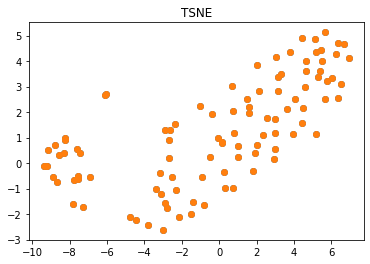

In [26]:
for i in range(2):
    plt.plot(tsne_img_emb.transpose()[0],tsne_img_emb.transpose()[1],'.',markersize=12)
plt.title("TSNE")
plt.show()

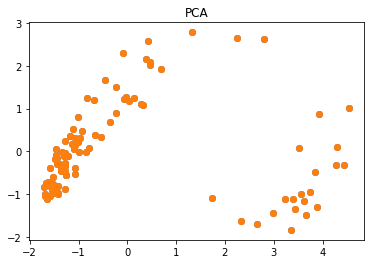

In [27]:
for i in range(2):
    plt.plot(pca_img_emb.transpose()[0], pca_img_emb.transpose()[1],'.',markersize=12)
plt.title("PCA")
plt.show()

In [28]:
tri_pred_temps = tri_reg_model.predict(tri_t10_data_emb).reshape(10,-1)
sq_pred_temps = tri_reg_model.predict(sq_t10_data_emb).reshape(10,-1)

In [29]:
all_tri_class_probas = tri_CNN_model.predict_proba(tri_t10_img).reshape(10,-1,4)
all_sq_class_probas = sq_CNN_model.predict_proba(sq_t10_img).reshape(10,-1,4)

In [30]:
avg_tri_class_probas = np.mean(all_tri_class_probas, axis=1)
avg_sq_class_probas = np.mean(all_sq_class_probas, axis=1)

In [31]:
from scipy.spatial import distance

tri_temp_list = []
sq_temp_list = []

for proba in avg_tri_class_probas:
    dist_list = []
    for proba_2 in tri_sim_data_probas:
        dist_list.append(distance.euclidean(proba, proba_2))
    max_idx = dist_list.index(min(dist_list))
    tri_temp_list.append(temps_vec[max_idx])
    
for proba in avg_sq_class_probas:
    dist_list = []
    for proba_2 in sq_sim_data_probas:
        dist_list.append(distance.euclidean(proba, proba_2))
    max_idx = dist_list.index(min(dist_list))
    sq_temp_list.append(temps_vec[max_idx])

In [32]:
sq_temp_list

[4.47,
 2.53,
 2.1199999999999997,
 1.23,
 0.5800000000000001,
 2.94,
 2.8299999999999996,
 1.9100000000000001,
 3.86,
 1.35]

In [33]:
tri_temp_list

[4.89,
 3.59,
 4.28,
 3.8899999999999997,
 4.4399999999999995,
 4.43,
 4.79,
 2.42,
 5.06,
 3.1399999999999997]

### (d) *Transfer Learning*.  
As we emphasize in class, one can freeze the training of the bottom layers of a network and retrain the top part of the network to adopt to a new situation. Use your CNN that you trained on the squarelattice data to do transfer learning on the triangular lattice data.  How does the performance compare to that of the direct methods?  Add the performance numbers for transfer learning in your table from Part (a). Note that the training time and number of training examples needed for transfer learning is far less than that for the direct  optimization. For  example,  is  50  triangle  example  sufficient  for the re-training process?  Use your transfer learning result to predict the transition temperature of triangle lattice Ising model, as demonstrated in this [Nature Physics](https://www-nature-com.ezp-prod1.hul.harvard.edu/articles/nphys4035.pdf) publication.

As a guideline, you may like to just change the last `Dense` layer with `softmax` activation when you do the transfer learning. Other choices are also OK.

Solution to (d):

In [34]:
base_model = sq_CNN_model

In [35]:
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
dropout_10 (Dropout)         (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)             

In [36]:
base_layers = base_model.layers[0:5]
trainable_layers = [
     Flatten(),
     Dropout(0.25),
     Dense(32, activation='relu'),
     Dense(num_classes, activation='softmax')
]

In [37]:
trans_model = keras.Sequential(base_layers+trainable_layers)
trans_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)             

In [38]:
input_shape = (32, 32, 1)
num_classes = 4
hyperparams = (0.01, 25, 32)
H_trans, trained_trans_model = train_model(trans_model, Xtri_train, ytri_train, Xtri_test, ytri_test, num_classes, input_shape, hyperparams)

Train on 800 samples, validate on 200 samples
Epoch 1/25
800/800 [==============================] - 0s 456us/sample - loss: 0.7291 - accuracy: 0.6862 - val_loss: 0.4746 - val_accuracy: 0.8000
Epoch 2/25
800/800 [==============================] - 0s 100us/sample - loss: 0.4772 - accuracy: 0.7825 - val_loss: 1.2475 - val_accuracy: 0.3600
Epoch 3/25
800/800 [==============================] - 0s 116us/sample - loss: 0.3944 - accuracy: 0.8363 - val_loss: 0.4983 - val_accuracy: 0.7600
Epoch 4/25
800/800 [==============================] - 0s 111us/sample - loss: 0.3043 - accuracy: 0.8737 - val_loss: 0.2966 - val_accuracy: 0.8850
Epoch 5/25
800/800 [==============================] - 0s 106us/sample - loss: 0.2616 - accuracy: 0.8900 - val_loss: 0.3586 - val_accuracy: 0.8600
Epoch 6/25
800/800 [==============================] - 0s 110us/sample - loss: 0.2762 - accuracy: 0.8863 - val_loss: 0.2119 - val_accuracy: 0.9300
Epoch 7/25
800/800 [==============================] - 0s 122us/sample - loss: 

In [39]:
proba_ests = trained_trans_model.predict_proba(tri_sim_img)

In [54]:
dist_from_chance = []
for proba in proba_ests:
    dist_from_chance.append(distance.euclidean(proba,[0.25, 0.25, 0.25, 0.25]))
    
min_idx = dist_from_chance.index(min(dist_from_chance))

In [57]:
print("Estimated Transition Tempurature:", temps_vec[min_idx])

Estimated Transition Tempurature: 2.94


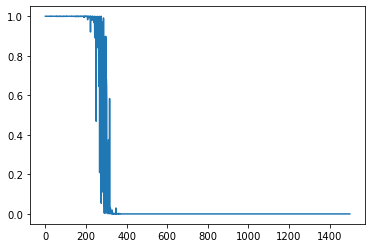

In [41]:
plt.plot(proba_ests[:,0])

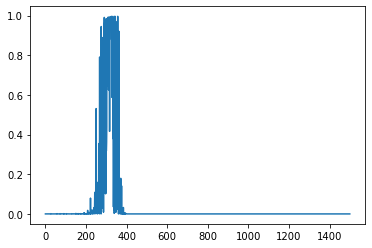

In [42]:
plt.plot(proba_ests[:,1])

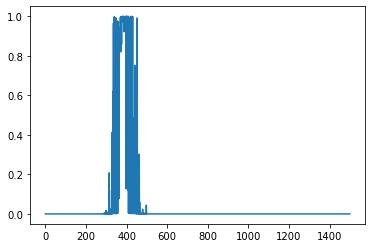

In [43]:
plt.plot(proba_ests[:,2])

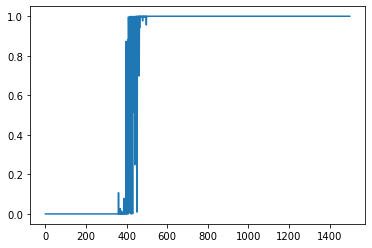

In [44]:
plt.plot(proba_ests[:,3])